In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,compute_rbf_mmd_median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass

set_seed(0)



0

In [2]:
#Base distribution
toy_data = get_distribution("toy_2d")
MOG = toy_data()
num_samples = 1000
mixture_samples =MOG.sample(num_samples)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)

/tmp/ipykernel_40601/4048455916.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)


In [3]:
dpi = 150
plt.style.use("../../matplotlibrc")
plt.rcParams.update({"figure.dpi": dpi})



@dataclass
class FigureLayout:
    width_in_pt: float
    width_grid: int
    base_font_size: int = 8
    scale_factor: float = 1.0

    # matplotlib uses inch
    def _get_grid_in_inch(self, w_grid, h_grid):
        pt_to_inch = 1 / 72
        assert w_grid <= self.width_grid
        return (
            (w_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
            (h_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
        )

    def get_rc(self, w_grid, h_grid):
        return {
            "figure.figsize": self._get_grid_in_inch(w_grid, h_grid),
            "font.size": self.base_font_size * self.scale_factor,
        }
    
textwidth=469
fig_handler = FigureLayout(469,100)
params = fig_handler.get_rc(40,30)
plt.rcParams.update(params)


In [4]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.mean = nn.Parameter(torch.zeros(dim))
        self.lower_triangular = nn.Parameter(torch.ones(dim*(dim+1)//2))
        self._row_ix, self._column_ix = torch.triu_indices(dim,dim)
        self.dim = dim

    def forward(self, noise):
        sample = self.cov_lt().matmul(noise.transpose(-2,-1)).transpose(-2,-1) + self.mean.unsqueeze(0)
        return sample
    
    def sample(self,size):
        return self.forward(torch.randn(size, self.dim))
    
    def cov(self):
        return self.cov_lt().matmul(self.cov_lt().transpose(-2,-1))
    
    def cov_lt(self):
        cov = torch.zeros(self.dim,self.dim)
        cov[self._row_ix,self._column_ix] = self.lower_triangular
        return cov






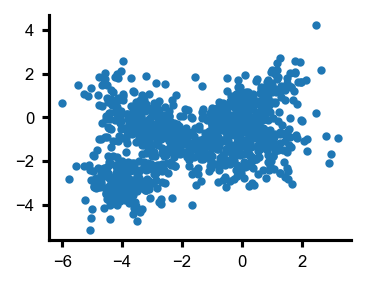

In [5]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")

In [6]:
# C2ST

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 10)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(10, 10)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x.squeeze()
    
nnc = NN()

loss_fn = torch.nn.BCELoss()  # binary cross entropy
gauss_model_C2ST = Gauss(dim=2)
num_samples = 10000


In [14]:


optimizer = torch.optim.Adam(nnc.parameters(), lr=0.01)
optimizer_G = torch.optim.Adam(gauss_model_C2ST.parameters(), lr=0.01)

nnc.train()
gauss_model_C2ST.train()

num_epochs = 100
for epoch in range(num_epochs):
    gauss_model_C2ST.zero_grad()
    nnc.zero_grad()

    samples = gauss_model_C2ST.sample(num_samples)
    mixture_samples = MOG.sample(num_samples)    #print(samples)

    x = torch.concat([samples.detach(),mixture_samples],dim=0)
    y_hat = torch.concat([torch.zeros(num_samples),torch.ones(num_samples)],dim=0)
    y = nnc(x) 
    loss_NN = loss_fn(y,y_hat) 

    x = torch.concat([samples,mixture_samples],dim=0)
    y_hat = torch.concat([torch.zeros(num_samples),torch.ones(num_samples)],dim=0)
    y = nnc(x)
    loss_G = torch.mean((y-0.5)**2)


    (loss_G+loss_NN).backward()
    #loss_NN.backward()
    optimizer.step()
    optimizer_G.step()



    acc = (y.detach().round() == y_hat).float().mean()    
    #print(acc)
    print("Iter: {}  acc: {}    loss: {}".format(epoch, acc,loss_G.item()))


gauss_model_C2ST.eval()



Iter: 0  acc: 0.7142999768257141    loss: 0.03716694563627243
Iter: 1  acc: 0.7203500270843506    loss: 0.033552709966897964
Iter: 2  acc: 0.722599983215332    loss: 0.03579557314515114
Iter: 3  acc: 0.7247999906539917    loss: 0.03755335137248039
Iter: 4  acc: 0.7327499985694885    loss: 0.03771543875336647
Iter: 5  acc: 0.7397500276565552    loss: 0.036724790930747986
Iter: 6  acc: 0.7438499927520752    loss: 0.036046575754880905
Iter: 7  acc: 0.7493000030517578    loss: 0.03553634509444237
Iter: 8  acc: 0.7530500292778015    loss: 0.03685770928859711
Iter: 9  acc: 0.751550018787384    loss: 0.0390680655837059
Iter: 10  acc: 0.7519000172615051    loss: 0.04029740020632744
Iter: 11  acc: 0.7543500065803528    loss: 0.04200020805001259
Iter: 12  acc: 0.7581999897956848    loss: 0.04320083186030388
Iter: 13  acc: 0.7595499753952026    loss: 0.04305832087993622
Iter: 14  acc: 0.7655500173568726    loss: 0.04440503939986229
Iter: 15  acc: 0.7670000195503235    loss: 0.045341745018959045
I

Gauss()

In [8]:
# MMD

gauss_model_MMD = Gauss(dim=2)
num_samples = 10000
with torch.no_grad():
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)
    bandwidth = compute_rbf_mmd_median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)
optimizer = torch.optim.Adam(gauss_model_MMD.parameters(), lr=0.01)
gauss_model_MMD.train()
num_epochs = 20
for epoch in range(num_epochs):
    gauss_model_MMD.zero_grad()
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = compute_rbf_mmd(samples, uniform_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_MMD.eval()



bandwidth:  tensor(0.0001)
Iter: 0     loss: 0.00018637758330442011
Iter: 1     loss: 0.000186103890882805
Iter: 2     loss: 0.0001862960052676499
Iter: 3     loss: 0.00018667150288820267
Iter: 4     loss: 0.00018667902622837573
Iter: 5     loss: 0.00018594376160763204
Iter: 6     loss: 0.00018650952551979572
Iter: 7     loss: 0.0001868604012997821
Iter: 8     loss: 0.00018697022460401058
Iter: 9     loss: 0.00018645988893695176
Iter: 10     loss: 0.0001860779448179528
Iter: 11     loss: 0.0001864188234321773
Iter: 12     loss: 0.00018634014122653753
Iter: 13     loss: 0.00018636441382113844
Iter: 14     loss: 0.00018713557801675051
Iter: 15     loss: 0.00018615332373883575
Iter: 16     loss: 0.0001861924392869696
Iter: 17     loss: 0.00018580182222649455
Iter: 18     loss: 0.0001866380189312622
Iter: 19     loss: 0.00018575353897176683


Gauss()

In [9]:
# WS

gauss_model_WS = Gauss(dim=2)
with torch.no_grad():
    samples = gauss_model_WS.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)
    bandwidth = compute_rbf_mmd_median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)
optimizer = torch.optim.Adam(gauss_model_WS.parameters(), lr=0.1)
gauss_model_WS.train()
num_epochs = 20
for epoch in range(num_epochs):
    gauss_model_WS.zero_grad()
    samples = gauss_model_WS.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = sliced_wasserstein_distance(samples, uniform_samples)#, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_WS.eval()



bandwidth:  tensor(9.6321e-05)
Iter: 0     loss: 1.5636531114578247
Iter: 1     loss: 1.340574860572815
Iter: 2     loss: 1.2748527526855469
Iter: 3     loss: 1.1838370561599731
Iter: 4     loss: 0.9675195813179016
Iter: 5     loss: 0.8712455630302429
Iter: 6     loss: 0.8712659478187561
Iter: 7     loss: 0.8186933994293213
Iter: 8     loss: 0.6847776770591736
Iter: 9     loss: 0.6775786280632019
Iter: 10     loss: 0.5708068013191223
Iter: 11     loss: 0.5606873631477356
Iter: 12     loss: 0.40078866481781006
Iter: 13     loss: 0.4314960241317749
Iter: 14     loss: 0.36581307649612427
Iter: 15     loss: 0.33339932560920715
Iter: 16     loss: 0.2766098976135254
Iter: 17     loss: 0.26167717576026917
Iter: 18     loss: 0.2759985327720642
Iter: 19     loss: 0.2271074503660202


Gauss()

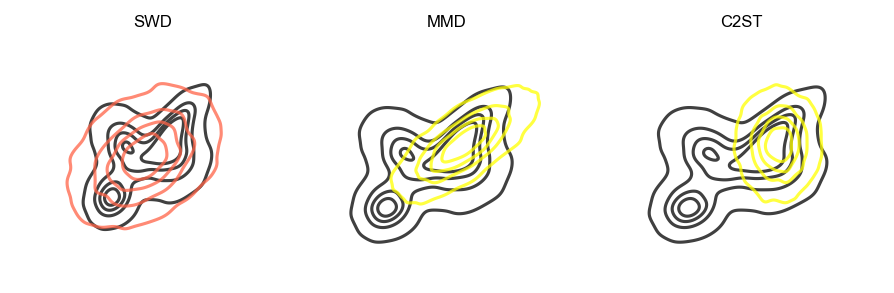

In [15]:
SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
C2ST_df = pd.DataFrame({'x': C2ST_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,3, figsize = (6,2))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)

sns.kdeplot(ax=axs[0],data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=MMD_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=C2ST_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.5, 1.5)
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title("SWD")
axs[1].set_title("MMD")
axs[2].set_title("C2ST")

fig.tight_layout()
